In [1]:
# ignore warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report
import eli5

In [3]:
data = pd.read_csv("data/ner_dataset.csv", encoding="utf-8")
data = data.fillna(method="ffill")
data.tail(10)

,Sentence #,Word,Tag
369382,Sentence: 16858,vùng,O
369383,Sentence: 16858,chôn_cất,O
369384,Sentence: 16858,người_thân,O
369385,Sentence: 16858,khi,O
369386,Sentence: 16858,qua_đời,O
369387,Sentence: 16858,",",O
369388,Sentence: 16858,gọi,O
369389,Sentence: 16858,là,O
369390,Sentence: 16858,nhị_tì,O
369391,Sentence: 16858,...,O


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

19152

In [5]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

5

In [6]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Đó', 'O'), ('là', 'O'), ('con', 'O'), ('đường', 'O'), ('biển', 'O'), ('ngắn', 'O'), ('nhất', 'O'), ('để', 'O'), ('đi', 'O'), ('từ', 'O'), ('Ấn_Độ_Dương', 'LOCATION'), ('sang', 'O'), ('Thái_Bình_Dương', 'LOCATION'), (',', 'O'), ('chiếm', 'O'), ('đến', 'O'), ('lượng', 'O'), ('hàng_hoá', 'O'), ('lưu_thông', 'O'), ('đường_biển', 'O'), ('của', 'O'), ('thế_giới', 'O'), (',', 'O'), ('đó', 'O'), ('là', 'O'), ('hải_trình', 'O'), ('lớn', 'O'), ('nhất', 'O'), ('từ', 'O'), ('tây', 'O'), ('sang', 'O'), ('đông', 'O'), ('với', 'O'), ('50.000', 'O'), ('lượt', 'O'), ('tàu_bè', 'O'), ('qua_lại', 'O'), ('mỗi', 'O'), ('năm', 'O'), ('...', 'O')]


In [8]:
sentences = getter.sentences

In [12]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [13]:
word2idx["cửa_hàng"]

14184

In [15]:
tag2idx["LOCATION"]

4

In [16]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [18]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [19]:
from keras.utils import to_categorical

y = [to_categorical(i, num_classes=n_tags) for i in y]

In [20]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [24]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
# fix issue here: https://github.com/ekholabs/keras-contrib/commit/0dac2da8a19f34946448121c6b9c8535bfb22ce2#diff-0970ecd5f755557421e7ba7716bdfd6a

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            383060    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 5)             290       
Total params: 416,800
Trainable params: 416,800
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Train on 13654 samples, validate on 1518 samples
Epoch 1/5


 6592/13654 [=============>................] - ETA: 37:54 - loss: 1.1302 - acc: 0.00 - ETA: 19:34 - loss: 1.1025 - acc: 0.00 - ETA: 13:25 - loss: 1.0754 - acc: 0.00 - ETA: 10:22 - loss: 1.0437 - acc: 0.22 - ETA: 8:31 - loss: 1.0067 - acc: 0.3748 - ETA: 7:18 - loss: 0.9590 - acc: 0.474 - ETA: 6:24 - loss: 0.8788 - acc: 0.548 - ETA: 5:45 - loss: 0.7853 - acc: 0.603 - ETA: 5:14 - loss: 0.7097 - acc: 0.645 - ETA: 4:49 - loss: 0.6478 - acc: 0.679 - ETA: 4:29 - loss: 0.5986 - acc: 0.707 - ETA: 4:12 - loss: 0.5584 - acc: 0.730 - ETA: 3:58 - loss: 0.5213 - acc: 0.750 - ETA: 3:45 - loss: 0.4916 - acc: 0.766 - ETA: 3:34 - loss: 0.4656 - acc: 0.780 - ETA: 3:25 - loss: 0.4442 - acc: 0.793 - ETA: 3:16 - loss: 0.4248 - acc: 0.804 - ETA: 3:09 - loss: 0.4048 - acc: 0.814 - ETA: 3:02 - loss: 0.3878 - acc: 0.823 - ETA: 2:56 - loss: 0.3709 - acc: 0.831 - ETA: 2:51 - loss: 0.3571 - acc: 0.838 - ETA: 2:46 - loss: 0.3448 - acc: 0.845 - ETA: 2:41 - loss: 0.3328 - acc: 0.851 - ETA: 2:37 - loss: 0.3224 - acc: 

13472/13654 [============================>.] - ETA: 42s - loss: 0.1034 - acc: 0.96 - ETA: 42s - loss: 0.1031 - acc: 0.96 - ETA: 41s - loss: 0.1029 - acc: 0.96 - ETA: 41s - loss: 0.1028 - acc: 0.96 - ETA: 41s - loss: 0.1025 - acc: 0.96 - ETA: 41s - loss: 0.1023 - acc: 0.96 - ETA: 40s - loss: 0.1019 - acc: 0.96 - ETA: 40s - loss: 0.1017 - acc: 0.96 - ETA: 40s - loss: 0.1014 - acc: 0.96 - ETA: 40s - loss: 0.1013 - acc: 0.96 - ETA: 40s - loss: 0.1010 - acc: 0.96 - ETA: 39s - loss: 0.1008 - acc: 0.96 - ETA: 39s - loss: 0.1006 - acc: 0.96 - ETA: 39s - loss: 0.1003 - acc: 0.96 - ETA: 39s - loss: 0.1000 - acc: 0.96 - ETA: 38s - loss: 0.0998 - acc: 0.96 - ETA: 38s - loss: 0.0995 - acc: 0.96 - ETA: 38s - loss: 0.0993 - acc: 0.96 - ETA: 38s - loss: 0.0990 - acc: 0.96 - ETA: 38s - loss: 0.0988 - acc: 0.96 - ETA: 37s - loss: 0.0986 - acc: 0.96 - ETA: 37s - loss: 0.0984 - acc: 0.96 - ETA: 37s - loss: 0.0982 - acc: 0.96 - ETA: 37s - loss: 0.0979 - acc: 0.96 - ETA: 37s - loss: 0.0976 - acc: 0.96 - ETA

13654/13654 [==============================] - ETA: 0s - loss: 0.0705 - acc: 0.977 - ETA: 0s - loss: 0.0704 - acc: 0.977 - ETA: 0s - loss: 0.0703 - acc: 0.977 - ETA: 0s - loss: 0.0703 - acc: 0.977 - ETA: 0s - loss: 0.0702 - acc: 0.977 - 79s 6ms/step - loss: 0.0702 - acc: 0.9771 - val_loss: 0.0310 - val_acc: 0.9896
Epoch 2/5


 6784/13654 [=============>................] - ETA: 1:13 - loss: 0.0406 - acc: 0.985 - ETA: 1:12 - loss: 0.0335 - acc: 0.988 - ETA: 1:12 - loss: 0.0317 - acc: 0.988 - ETA: 1:09 - loss: 0.0311 - acc: 0.989 - ETA: 1:08 - loss: 0.0297 - acc: 0.990 - ETA: 1:07 - loss: 0.0282 - acc: 0.990 - ETA: 1:08 - loss: 0.0261 - acc: 0.991 - ETA: 1:07 - loss: 0.0265 - acc: 0.991 - ETA: 1:07 - loss: 0.0254 - acc: 0.991 - ETA: 1:07 - loss: 0.0262 - acc: 0.991 - ETA: 1:07 - loss: 0.0263 - acc: 0.991 - ETA: 1:06 - loss: 0.0269 - acc: 0.990 - ETA: 1:07 - loss: 0.0279 - acc: 0.990 - ETA: 1:06 - loss: 0.0271 - acc: 0.990 - ETA: 1:06 - loss: 0.0270 - acc: 0.990 - ETA: 1:06 - loss: 0.0269 - acc: 0.990 - ETA: 1:05 - loss: 0.0274 - acc: 0.990 - ETA: 1:05 - loss: 0.0271 - acc: 0.990 - ETA: 1:05 - loss: 0.0275 - acc: 0.990 - ETA: 1:05 - loss: 0.0275 - acc: 0.990 - ETA: 1:05 - loss: 0.0276 - acc: 0.990 - ETA: 1:05 - loss: 0.0281 - acc: 0.990 - ETA: 1:04 - loss: 0.0292 - acc: 0.990 - ETA: 1:04 - loss: 0.0286 - acc: 0

13654/13654 [==============================] - ETA: 33s - loss: 0.0268 - acc: 0.99 - ETA: 33s - loss: 0.0268 - acc: 0.99 - ETA: 33s - loss: 0.0268 - acc: 0.99 - ETA: 33s - loss: 0.0267 - acc: 0.99 - ETA: 33s - loss: 0.0267 - acc: 0.99 - ETA: 33s - loss: 0.0266 - acc: 0.99 - ETA: 32s - loss: 0.0266 - acc: 0.99 - ETA: 32s - loss: 0.0266 - acc: 0.99 - ETA: 32s - loss: 0.0265 - acc: 0.99 - ETA: 32s - loss: 0.0265 - acc: 0.99 - ETA: 32s - loss: 0.0265 - acc: 0.99 - ETA: 32s - loss: 0.0265 - acc: 0.99 - ETA: 31s - loss: 0.0265 - acc: 0.99 - ETA: 31s - loss: 0.0265 - acc: 0.99 - ETA: 31s - loss: 0.0265 - acc: 0.99 - ETA: 31s - loss: 0.0265 - acc: 0.99 - ETA: 31s - loss: 0.0265 - acc: 0.99 - ETA: 31s - loss: 0.0265 - acc: 0.99 - ETA: 31s - loss: 0.0265 - acc: 0.99 - ETA: 30s - loss: 0.0265 - acc: 0.99 - ETA: 30s - loss: 0.0265 - acc: 0.99 - ETA: 30s - loss: 0.0265 - acc: 0.99 - ETA: 30s - loss: 0.0264 - acc: 0.99 - ETA: 30s - loss: 0.0264 - acc: 0.99 - ETA: 30s - loss: 0.0264 - acc: 0.99 - ETA

Epoch 3/5


 6720/13654 [=============>................] - ETA: 1:06 - loss: 0.0067 - acc: 0.997 - ETA: 1:12 - loss: 0.0136 - acc: 0.994 - ETA: 1:12 - loss: 0.0164 - acc: 0.993 - ETA: 1:12 - loss: 0.0155 - acc: 0.994 - ETA: 1:12 - loss: 0.0158 - acc: 0.994 - ETA: 1:12 - loss: 0.0176 - acc: 0.994 - ETA: 1:12 - loss: 0.0181 - acc: 0.994 - ETA: 1:11 - loss: 0.0179 - acc: 0.994 - ETA: 1:11 - loss: 0.0197 - acc: 0.993 - ETA: 1:11 - loss: 0.0188 - acc: 0.994 - ETA: 1:11 - loss: 0.0188 - acc: 0.993 - ETA: 1:11 - loss: 0.0187 - acc: 0.994 - ETA: 1:11 - loss: 0.0190 - acc: 0.994 - ETA: 1:11 - loss: 0.0190 - acc: 0.994 - ETA: 1:11 - loss: 0.0199 - acc: 0.993 - ETA: 1:11 - loss: 0.0197 - acc: 0.993 - ETA: 1:11 - loss: 0.0200 - acc: 0.993 - ETA: 1:10 - loss: 0.0205 - acc: 0.993 - ETA: 1:11 - loss: 0.0203 - acc: 0.993 - ETA: 1:10 - loss: 0.0200 - acc: 0.994 - ETA: 1:10 - loss: 0.0196 - acc: 0.994 - ETA: 1:10 - loss: 0.0195 - acc: 0.994 - ETA: 1:10 - loss: 0.0194 - acc: 0.994 - ETA: 1:09 - loss: 0.0194 - acc: 0

13600/13654 [============================>.] - ETA: 37s - loss: 0.0170 - acc: 0.99 - ETA: 37s - loss: 0.0170 - acc: 0.99 - ETA: 37s - loss: 0.0170 - acc: 0.99 - ETA: 37s - loss: 0.0170 - acc: 0.99 - ETA: 37s - loss: 0.0171 - acc: 0.99 - ETA: 36s - loss: 0.0170 - acc: 0.99 - ETA: 36s - loss: 0.0170 - acc: 0.99 - ETA: 36s - loss: 0.0170 - acc: 0.99 - ETA: 36s - loss: 0.0170 - acc: 0.99 - ETA: 36s - loss: 0.0170 - acc: 0.99 - ETA: 36s - loss: 0.0170 - acc: 0.99 - ETA: 35s - loss: 0.0170 - acc: 0.99 - ETA: 35s - loss: 0.0170 - acc: 0.99 - ETA: 35s - loss: 0.0171 - acc: 0.99 - ETA: 35s - loss: 0.0171 - acc: 0.99 - ETA: 35s - loss: 0.0170 - acc: 0.99 - ETA: 35s - loss: 0.0170 - acc: 0.99 - ETA: 34s - loss: 0.0171 - acc: 0.99 - ETA: 34s - loss: 0.0170 - acc: 0.99 - ETA: 34s - loss: 0.0171 - acc: 0.99 - ETA: 34s - loss: 0.0171 - acc: 0.99 - ETA: 34s - loss: 0.0171 - acc: 0.99 - ETA: 33s - loss: 0.0171 - acc: 0.99 - ETA: 33s - loss: 0.0171 - acc: 0.99 - ETA: 33s - loss: 0.0171 - acc: 0.99 - ETA

13654/13654 [==============================] - ETA: 0s - loss: 0.0159 - acc: 0.994 - 77s 6ms/step - loss: 0.0159 - acc: 0.9945 - val_loss: 0.0145 - val_acc: 0.9947
Epoch 4/5


 6720/13654 [=============>................] - ETA: 1:13 - loss: 0.0095 - acc: 0.997 - ETA: 1:12 - loss: 0.0093 - acc: 0.997 - ETA: 1:12 - loss: 0.0105 - acc: 0.996 - ETA: 1:12 - loss: 0.0124 - acc: 0.995 - ETA: 1:12 - loss: 0.0122 - acc: 0.994 - ETA: 1:13 - loss: 0.0125 - acc: 0.994 - ETA: 1:13 - loss: 0.0129 - acc: 0.994 - ETA: 1:12 - loss: 0.0126 - acc: 0.995 - ETA: 1:12 - loss: 0.0129 - acc: 0.995 - ETA: 1:12 - loss: 0.0129 - acc: 0.994 - ETA: 1:12 - loss: 0.0121 - acc: 0.995 - ETA: 1:11 - loss: 0.0120 - acc: 0.995 - ETA: 1:11 - loss: 0.0122 - acc: 0.995 - ETA: 1:11 - loss: 0.0122 - acc: 0.995 - ETA: 1:11 - loss: 0.0121 - acc: 0.995 - ETA: 1:10 - loss: 0.0123 - acc: 0.995 - ETA: 1:11 - loss: 0.0121 - acc: 0.995 - ETA: 1:10 - loss: 0.0120 - acc: 0.995 - ETA: 1:10 - loss: 0.0125 - acc: 0.995 - ETA: 1:10 - loss: 0.0130 - acc: 0.995 - ETA: 1:10 - loss: 0.0129 - acc: 0.995 - ETA: 1:10 - loss: 0.0127 - acc: 0.995 - ETA: 1:10 - loss: 0.0124 - acc: 0.995 - ETA: 1:09 - loss: 0.0128 - acc: 0

13600/13654 [============================>.] - ETA: 37s - loss: 0.0118 - acc: 0.99 - ETA: 37s - loss: 0.0117 - acc: 0.99 - ETA: 37s - loss: 0.0118 - acc: 0.99 - ETA: 37s - loss: 0.0118 - acc: 0.99 - ETA: 37s - loss: 0.0118 - acc: 0.99 - ETA: 37s - loss: 0.0118 - acc: 0.99 - ETA: 36s - loss: 0.0118 - acc: 0.99 - ETA: 36s - loss: 0.0118 - acc: 0.99 - ETA: 36s - loss: 0.0118 - acc: 0.99 - ETA: 36s - loss: 0.0118 - acc: 0.99 - ETA: 36s - loss: 0.0118 - acc: 0.99 - ETA: 36s - loss: 0.0118 - acc: 0.99 - ETA: 35s - loss: 0.0118 - acc: 0.99 - ETA: 35s - loss: 0.0118 - acc: 0.99 - ETA: 35s - loss: 0.0118 - acc: 0.99 - ETA: 35s - loss: 0.0118 - acc: 0.99 - ETA: 35s - loss: 0.0118 - acc: 0.99 - ETA: 34s - loss: 0.0118 - acc: 0.99 - ETA: 34s - loss: 0.0118 - acc: 0.99 - ETA: 34s - loss: 0.0118 - acc: 0.99 - ETA: 34s - loss: 0.0118 - acc: 0.99 - ETA: 34s - loss: 0.0118 - acc: 0.99 - ETA: 34s - loss: 0.0117 - acc: 0.99 - ETA: 33s - loss: 0.0117 - acc: 0.99 - ETA: 33s - loss: 0.0117 - acc: 0.99 - ETA

13654/13654 [==============================] - ETA: 0s - loss: 0.0113 - acc: 0.995 - 78s 6ms/step - loss: 0.0113 - acc: 0.9958 - val_loss: 0.0125 - val_acc: 0.9953
Epoch 5/5


 6720/13654 [=============>................] - ETA: 1:26 - loss: 0.0051 - acc: 0.997 - ETA: 1:22 - loss: 0.0043 - acc: 0.998 - ETA: 1:19 - loss: 0.0056 - acc: 0.997 - ETA: 1:17 - loss: 0.0084 - acc: 0.997 - ETA: 1:17 - loss: 0.0075 - acc: 0.997 - ETA: 1:16 - loss: 0.0070 - acc: 0.997 - ETA: 1:16 - loss: 0.0069 - acc: 0.997 - ETA: 1:16 - loss: 0.0068 - acc: 0.997 - ETA: 1:15 - loss: 0.0070 - acc: 0.997 - ETA: 1:14 - loss: 0.0076 - acc: 0.997 - ETA: 1:14 - loss: 0.0076 - acc: 0.997 - ETA: 1:14 - loss: 0.0077 - acc: 0.997 - ETA: 1:14 - loss: 0.0076 - acc: 0.997 - ETA: 1:14 - loss: 0.0073 - acc: 0.997 - ETA: 1:14 - loss: 0.0072 - acc: 0.997 - ETA: 1:14 - loss: 0.0078 - acc: 0.996 - ETA: 1:13 - loss: 0.0079 - acc: 0.996 - ETA: 1:13 - loss: 0.0080 - acc: 0.996 - ETA: 1:13 - loss: 0.0078 - acc: 0.997 - ETA: 1:13 - loss: 0.0080 - acc: 0.996 - ETA: 1:13 - loss: 0.0080 - acc: 0.996 - ETA: 1:12 - loss: 0.0080 - acc: 0.996 - ETA: 1:12 - loss: 0.0082 - acc: 0.996 - ETA: 1:12 - loss: 0.0081 - acc: 0

13600/13654 [============================>.] - ETA: 38s - loss: 0.0089 - acc: 0.99 - ETA: 38s - loss: 0.0089 - acc: 0.99 - ETA: 38s - loss: 0.0089 - acc: 0.99 - ETA: 38s - loss: 0.0089 - acc: 0.99 - ETA: 37s - loss: 0.0089 - acc: 0.99 - ETA: 37s - loss: 0.0089 - acc: 0.99 - ETA: 37s - loss: 0.0089 - acc: 0.99 - ETA: 37s - loss: 0.0088 - acc: 0.99 - ETA: 37s - loss: 0.0088 - acc: 0.99 - ETA: 36s - loss: 0.0088 - acc: 0.99 - ETA: 36s - loss: 0.0088 - acc: 0.99 - ETA: 36s - loss: 0.0088 - acc: 0.99 - ETA: 36s - loss: 0.0088 - acc: 0.99 - ETA: 36s - loss: 0.0088 - acc: 0.99 - ETA: 36s - loss: 0.0088 - acc: 0.99 - ETA: 35s - loss: 0.0088 - acc: 0.99 - ETA: 35s - loss: 0.0088 - acc: 0.99 - ETA: 35s - loss: 0.0088 - acc: 0.99 - ETA: 35s - loss: 0.0088 - acc: 0.99 - ETA: 35s - loss: 0.0088 - acc: 0.99 - ETA: 34s - loss: 0.0088 - acc: 0.99 - ETA: 34s - loss: 0.0088 - acc: 0.99 - ETA: 34s - loss: 0.0088 - acc: 0.99 - ETA: 34s - loss: 0.0088 - acc: 0.99 - ETA: 34s - loss: 0.0088 - acc: 0.99 - ETA

13654/13654 [==============================] - ETA: 0s - loss: 0.0086 - acc: 0.996 - 78s 6ms/step - loss: 0.0086 - acc: 0.9968 - val_loss: 0.0105 - val_acc: 0.9960


In [26]:
hist = pd.DataFrame(history.history)

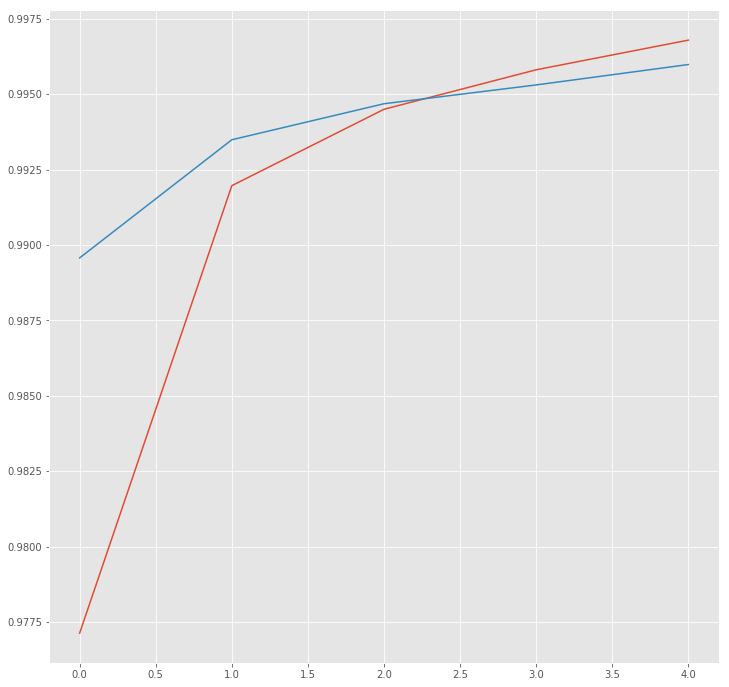

In [27]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [30]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

test_pred = model.predict(X_te, verbose=1)

1686/1686 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 2ms/step


In [31]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

In [32]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 84.1%


In [33]:
print(classification_report(test_labels, pred_labels))

             precision    recall  f1-score   support

     PERSON       0.88      0.88      0.88       710
       MISC       0.91      0.67      0.78        46
   LOCATION       0.82      0.79      0.80       631

avg / total       0.85      0.83      0.84      1387



In [35]:
i = 202
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
Một            : O     O
thành_viên     : O     O
trong          : O     O
ban            : O     O
huấn_luyện     : O     O
cho            : O     O
biết           : O     O
:              : O     O
Ban_đầu        : O     O
các            : O     O
võ_sĩ          : O     O
VN             : LOCATION LOCATION
đã             : O     O
lắc_đầu_lè_lưỡi: O     O
khi            : O     O
được           : O     O
xem            : O     O
các            : O     O
trận           : O     O
đấu            : O     O
chuyên_nghiệp  : O     O
của            : O     O
võ_sĩ          : O     O
Thái           : LOCATION PERSON
.              : O     O
Xóm_Củi        : O     O
Xóm_Củi        : O     O
Xóm_Củi        : O     O
Xóm_Củi        : O     O
Xóm_Củi        : O     O
Xóm_Củi        : O     O
Xóm_Củi        : O     O
Xóm_Củi        : O     O
Xóm_Củi        : O     O
Xóm_Củi        : O     O
Xóm_Củi        : O     O
Xóm_Củi        : O     O
Xóm_Củi        : O     O
Xóm

In [43]:
from underthesea import word_tokenize

sentence = "Phạm Bảo Sơn là một nhà khoa học máy tính của Việt Nam. Ông là Phó Hiệu trưởng của Trường Đại học Công nghệ, Đại học Quốc gia Hà Nội và là người Việt Nam đầu tiên đoạt giải thưởng IBM Faculty Award vào năm 2010. Trong các lĩnh vực của ngành khoa học máy tính, ông có nhiều thành tựu trong lĩnh vực xử lý ngôn ngữ tự nhiên."
test_sentence = word_tokenize(sentence)
test_sentence = [token.replace(" ", "_") for token in test_sentence]
print(test_sentence)

['Phạm', 'Bảo_Sơn', 'là', 'một', 'nhà', 'khoa_học', 'máy_tính', 'của', 'Việt_Nam', '.', 'Ông', 'là', 'Phó_Hiệu_trưởng', 'của', 'Trường', 'Đại_học', 'Công_nghệ', ',', 'Đại_học', 'Quốc_gia', 'Hà_Nội', 'và', 'là', 'người', 'Việt_Nam', 'đầu_tiên', 'đoạt', 'giải_thưởng', 'IBM', 'Faculty', 'Award', 'vào', 'năm', '2010', '.', 'Trong', 'các', 'lĩnh_vực', 'của', 'ngành', 'khoa_học', 'máy_tính', ',', 'ông', 'có', 'nhiều', 'thành_tựu', 'trong', 'lĩnh_vực', 'xử_lý', 'ngôn_ngữ', 'tự_nhiên', '.']


In [44]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)

In [45]:
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

Word           ||Prediction
Phạm           : PERSON
Bảo_Sơn        : PERSON
là             : O    
một            : O    
nhà            : O    
khoa_học       : O    
máy_tính       : O    
của            : O    
Việt_Nam       : LOCATION
.              : O    
Ông            : O    
là             : O    
Phó_Hiệu_trưởng: PERSON
của            : O    
Trường         : ORGANIZATION
Đại_học        : ORGANIZATION
Công_nghệ      : ORGANIZATION
,              : ORGANIZATION
Đại_học        : ORGANIZATION
Quốc_gia       : ORGANIZATION
Hà_Nội         : ORGANIZATION
và             : O    
là             : O    
người          : ORGANIZATION
Việt_Nam       : ORGANIZATION
đầu_tiên       : O    
đoạt           : O    
giải_thưởng    : O    
IBM            : ORGANIZATION
Faculty        : PERSON
Award          : O    
vào            : O    
năm            : O    
2010           : O    
.              : O    
Trong          : O    
các            : O    
lĩnh_vực       : O    
của            : O   